## Dataset download and library imports

In [17]:
!pip3 install -q kaggle keras_tuner
!pip3 install -U keras 

In [18]:
import tensorflow as tf
import keras
import keras_tuner
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import random
import logging
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import layers

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [19]:
credentials = json.load(open('kaggle.json'))
os.environ['KAGGLE_USERNAME'] = credentials['username']
os.environ['KAGGLE_KEY'] = credentials['key']

!mkdir dataset
!kaggle datasets download -d gsimonx37/letterboxd
!unzip letterboxd.zip -d dataset

# remove corrupted image
!rm "dataset/posters/1059895.jpg"

#### Global Parameters

Set the `FAST_TRAIN` parameter to true for reducing the execution time of the notebook

In [20]:
FAST_TRAIN = True 

In [81]:
BATCH_SIZE = 128
SUBSAMPLING_COEFF = 1 if not FAST_TRAIN else 0.04
MAX_EPOCHS = 15 if not FAST_TRAIN else 1
LABEL_PATH = "dataset/genres.csv"
MODELS_PATH = "models/"
IMG_PATH = "dataset/posters/"
IMG_SHAPE = (224,224,3)
AUTO = tf.data.AUTOTUNE

## Dataset Preprocessing

#### Genre distribution in the dataset

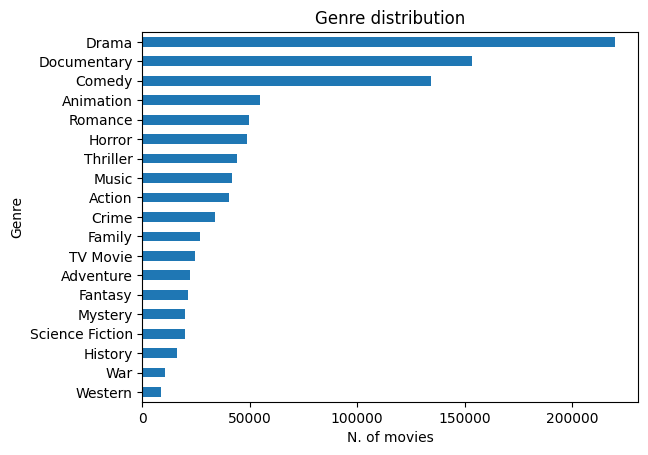

In [22]:
df = pd.read_csv(LABEL_PATH)
df.groupby("genre").count().sort_values(by="id").plot.barh(
    title="Genre distribution",
    xlabel="N. of movies",
    ylabel="Genre",
    log=False,
    legend=False,
)
plt.show()

In [23]:
df.head(8)

,id,genre
0,1000001,Comedy
1,1000001,Fantasy
2,1000001,Adventure
3,1000002,Comedy
4,1000002,Thriller
5,1000002,Drama
6,1000003,Science Fiction
7,1000003,Action


### Create the one-hot encoder for the labels

In [24]:
df["genre"] = df["genre"].apply(lambda x: x.replace(" ", "_"))
genres = df["genre"].unique()
genres = sorted(genres)

oneHotEncoder = sk.preprocessing.LabelBinarizer()
oneHotEncoder.fit(genres)

### Load and balance the Dataset

In [25]:
def load_ids(subsample=True) -> set[int]:
    df = pd.read_csv(LABEL_PATH)
    ID_set = set(df["id"])
    imageIDs = [int(f[:-4]) for f in os.listdir(IMG_PATH)]
    ID_set = ID_set.intersection(set(imageIDs))
    if subsample:
        return set(random.sample(list(ID_set), int(len(ID_set) * SUBSAMPLING_COEFF)))
    return ID_set


def load_labels(valid_IDs: set[int], multiLabel=False) -> pd.DataFrame:
    df = pd.read_csv(LABEL_PATH)
    df = df[df["id"].isin(valid_IDs)]
    if not multiLabel:
        sorted_genres = list(df.groupby("genre").count().sort_values(by="id").index)
        genre_importance = {genre: idx for idx, genre in enumerate(sorted_genres)}
        df["importance"] = df["genre"].map(genre_importance)
        df = df.sort_values(by=["id", "importance"])
        df = df.drop(columns=["importance"])
        df = df.drop_duplicates(subset="id", keep="first")
    df["genre"] = df["genre"].apply(lambda x: x.replace(" ", "_"))
    return df


def balance_labels(df: pd.DataFrame) -> pd.DataFrame:
    min_genre_count = df["genre"].value_counts().min()
    balanced_df = df.groupby("genre").apply(
        lambda group: group.sample(n=min_genre_count, replace=False),
    )
    balanced_df = balanced_df.reset_index(drop=True)
    return balanced_df


def encode_labels(df: pd.DataFrame) -> pd.Series:
    encodedLabels = oneHotEncoder.transform(df["genre"])
    encoded_df = pd.DataFrame({"id": df["id"], "label": list(encodedLabels)})
    return encoded_df.groupby("id").sum()


def load_image(record: dict) -> tuple[tf.Tensor, str]:
    image = tf.io.read_file(record["img"])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(
        image, target_height=IMG_SHAPE[1], target_width=IMG_SHAPE[0]
    )
    return image, record["label"]


def load_dataset(X: list[int], Y: list[str], reshuffle=True) -> tf.data.Dataset:
    labelTensor = tf.convert_to_tensor(list(oneHotEncoder.transform(Y)))
    image_files = [os.path.join(IMG_PATH, str(id) + ".jpg") for id in X]

    dataset = tf.data.Dataset.from_tensor_slices(
        {"img": image_files, "label": labelTensor}
    )
    dataset = dataset.shuffle(25_000, reshuffle_each_iteration=reshuffle)
    dataset = dataset.map(load_image, num_parallel_calls=AUTO)
    dataset = dataset.batch(
        batch_size=BATCH_SIZE,
        num_parallel_calls=AUTO,
        deterministic=False,
        drop_remainder=True,
    )
    dataset = dataset.prefetch(AUTO)
    return dataset


def make_splits(X: list[int], Y: list[str]) -> tuple[tf.data.Dataset]:
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.10, shuffle=True, stratify=Y
    )
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_train, Y_train, test_size=0.15, shuffle=True, stratify=Y_train
    )
    return (
        load_dataset(X_train, Y_train),
        load_dataset(X_val, Y_val),
        load_dataset(X_test, Y_test, reshuffle=False),
    )

In [26]:
ID_set = load_ids(subsample=(SUBSAMPLING_COEFF < 1))
labels = load_labels(ID_set, multiLabel=False)
labels = balance_labels(labels)
X = labels["id"].to_list()
Y = labels["genre"].to_list()

train_Data, validation_Data, test_Data = make_splits(X, Y)

print("Number of labeled movie posters: ", labels["id"].unique().size)
print(f"Labels' Dataframe size: {labels.memory_usage().sum() / 1E6:.2f} MBs")
print("Number of datapoints per class: ", labels.groupby("genre").count()["id"].min())

Number of labeled movie posters:  148618
Labels' Dataframe size: 3.57 MBs
Number of datapoints per class:  7822


In [27]:
labels.groupby('genre').count()

,id
genre,
Action,7822
Adventure,7822
Animation,7822
Comedy,7822
Crime,7822
Documentary,7822
Drama,7822
Family,7822
Fantasy,7822


### Show a random datapoint

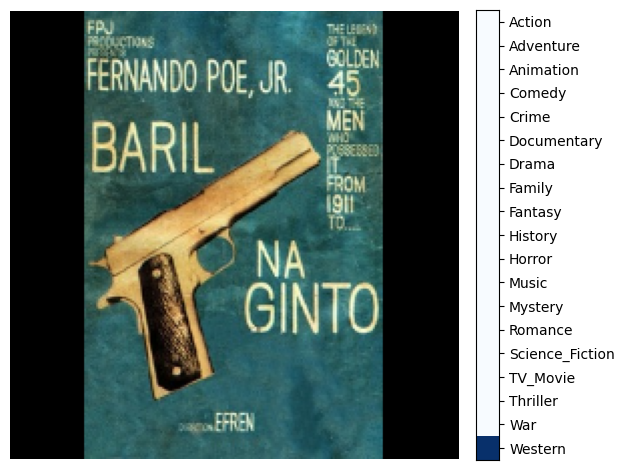

In [28]:
idx = random.randint(0, BATCH_SIZE - 1)
for img, label in train_Data.take(1).as_numpy_iterator():
    fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[5, 1], height_ratios=[1])
    img = img[idx]
    label = label[idx]
    ax1.imshow(img / 255)
    ax1.axis("off")
    data = np.array([label]).T
    cax = ax2.imshow(data, cmap="Blues", aspect="auto", interpolation="nearest")
    ax2.set_aspect(1)
    ax2.set_yticks(np.arange(len(label)))
    ax2.set_xticks([])
    ax2.set_yticklabels(genres)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.tight_layout()
    plt.show()
    break

#### Helper functions for plotting

In [29]:
def plot_datapoint(img: np.ndarray, label: np.ndarray, prediction: np.ndarray):
    _, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[5, 1], height_ratios=[1])
    ax1.imshow(img / 255)
    ax1.axis("off")
    data = np.vstack([label, prediction]).T
    ax2.imshow(data, cmap="Blues", aspect="auto", interpolation="nearest")
    ax2.set_aspect(0.9)
    ax2.set_yticks(np.arange(len(label)))
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(
        ["Label", "Prediction"], rotation=-50, ha="left", rotation_mode="anchor"
    )
    ax2.set_yticklabels(genres)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.tight_layout()
    plt.show()


def plot_random_datapoint(model: keras.Model, dataset: tf.data.Dataset):
    idx = random.randint(0, BATCH_SIZE - 1)
    for img, label in dataset.take(1).as_numpy_iterator():
        prediction = model.predict(tf.reshape(img[idx], (1, *IMG_SHAPE)), verbose=0)
        plot_datapoint(img[idx], label[idx], prediction)
        break


def plot_history(hst: keras.callbacks.History):
    metrics = ["loss", "accuracy", "recall"]
    _, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, metric in enumerate(metrics):
        ax[i].plot(hst.history[metric])
        ax[i].plot(hst.history["val_" + metric])
        ax[i].set(title="model " + metric, ylabel=metric, xlabel="epoch")
        ax[i].legend([metric, "val_" + metric], loc="upper left")
    plt.show()

## CNN training and evaluation

In [30]:
def build_model(hp: keras_tuner.HyperParameters):
    efficientNet = keras.applications.EfficientNetV2B0(
        include_top=False, weights="imagenet", input_shape=IMG_SHAPE, pooling="avg"
    )
    efficientNet.trainable = False

    input_layer = layers.Input(shape=IMG_SHAPE)
    x = efficientNet(input_layer, training=False)
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(units=hp.Int("units", min_value=64, max_value=512, step=64))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if hp.Boolean("dropout"):
        x = layers.Dropout(0.3)(x)

    out = layers.Dense(19, "softmax", name="out_layer")(x)

    model = keras.Model(input_layer, out, name="resNet_poster")

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", "recall"],
    )
    return model

### Perform model selection 

In [31]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=1 if FAST_TRAIN else 4,
    executions_per_trial=1 if FAST_TRAIN else 2,
    overwrite=True,
    project_name="posterCNN",
)

tuner.search(train_Data, epochs=1 if FAST_TRAIN else 3, validation_data=validation_Data)

Trial 4 Complete [00h 09m 01s]
val_accuracy: 0.2534555196762085

Best val_accuracy So Far: 0.25373096764087677
Total elapsed time: 00h 36m 15s


In [32]:
tuner.results_summary()

Results summary
Results in ./posterCNN
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
units: 320
dropout: True
Score: 0.25373096764087677

Trial 3 summary
Hyperparameters:
units: 512
dropout: True
Score: 0.2534555196762085

Trial 1 summary
Hyperparameters:
units: 128
dropout: False
Score: 0.25302985310554504

Trial 0 summary
Hyperparameters:
units: 128
dropout: True
Score: 0.25250400602817535


In [33]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
model = build_model(best_hyperparameters)
model.summary()

Model: "resNet_poster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 320)            │       328,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 19)             │         6,099 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,570,531 (28.88 MB)

 Trainable params: 1,648,531 (6.29 MB)

 Non-trainable params: 5,922,000 (22.59 MB)

### Model training

In [82]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
model = build_model(best_hyperparameters)

earlyStop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

history = model.fit(
    train_Data,
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    validation_data=validation_Data,
    callbacks=[earlyStop],
)

Epoch 1/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 112s 94ms/step - accuracy: 0.1756 - loss: 2.7582 - recall: 0.0272 - val_accuracy: 0.2415 - val_loss: 2.4500 - val_recall: 0.0374
Epoch 2/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.2338 - loss: 2.4748 - recall: 0.0373 - val_accuracy: 0.2479 - val_loss: 2.4217 - val_recall: 0.0437
Epoch 3/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 80s 90ms/step - accuracy: 0.2482 - loss: 2.4192 - recall: 0.0438 - val_accuracy: 0.2499 - val_loss: 2.4090 - val_recall: 0.0489
Epoch 4/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.2568 - loss: 2.3919 - recall: 0.0466 - val_accuracy: 0.2564 - val_loss: 2.3982 - val_recall: 0.0501
Epoch 5/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.2686 - loss: 2.3599 - recall: 0.0527 - val_accuracy: 0.2573 - val_loss: 2.3949 - val_recall: 0.0561
Epoch 6/15
888/888 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.2759 - loss: 2.3308 - recall: 0.0590 - val_accuracy: 0.2598 - val_loss: 2.3971 - val_recall

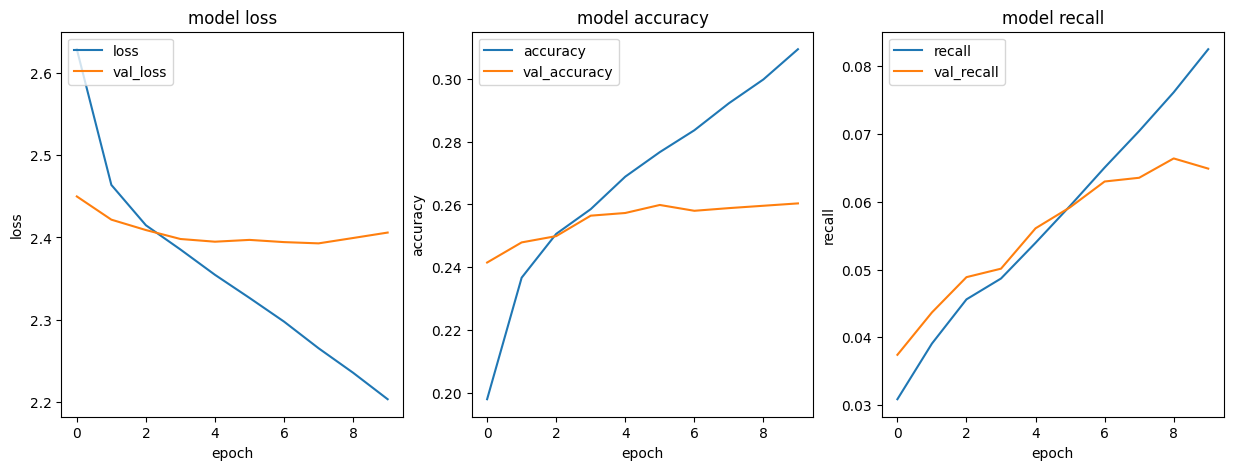

In [83]:
plot_history(history) 

### Evaluation on the test set

In [85]:
test_loss, test_acc, test_recall = model.evaluate(test_Data, batch_size=BATCH_SIZE)

print(
    f"Test Loss: \t\t{test_loss:.3f}\nTest Accuracy: \t{test_acc:.3f}\nTest Recall: \t{test_recall:.3f}"
)

116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.2522 - loss: 2.4361 - recall: 0.0619
Test Loss: 		2.409
Test Accuracy: 	0.259
Test Recall: 	0.066


### Classification report

In [86]:
y_pred = model.predict(test_Data)
y_pred_copy = []
for array in y_pred:
    max_idx = np.argmax([array])
    oneHot = np.zeros(19).astype(int)
    oneHot[max_idx] = 1
    y_pred_copy.append(oneHotEncoder.inverse_transform(np.array([oneHot])))


y_true = []
for batch in test_Data:
    for label in batch[1]:
        y_true.append(oneHotEncoder.inverse_transform(np.array([label])))

116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step


2024-07-18 15:39:31.179957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [87]:
rep = sk.metrics.classification_report(y_true, y_pred_copy, output_dict=True)
rep = pd.DataFrame(rep).T
rep.support = rep.support.astype(int)
rep.round(decimals=2)

,precision,recall,f1-score,support
Action,0.26,0.33,0.29,781
Adventure,0.19,0.13,0.15,781
Animation,0.35,0.58,0.44,783
Comedy,0.21,0.26,0.23,782
Crime,0.19,0.09,0.13,781
Documentary,0.18,0.28,0.22,783
Drama,0.14,0.18,0.16,781
Family,0.29,0.25,0.27,780
Fantasy,0.22,0.13,0.17,782
History,0.21,0.12,0.15,782


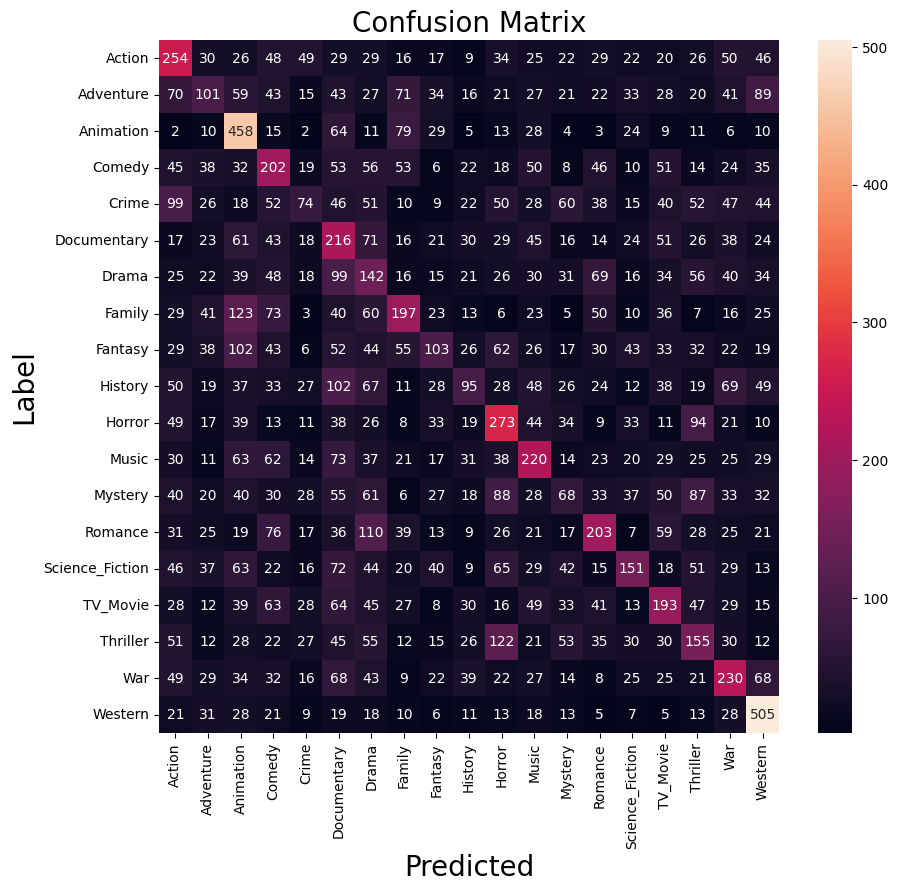

In [88]:
confusion_m = sk.metrics.confusion_matrix(y_true, y_pred_copy)

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot()
sns.heatmap(confusion_m, annot=True, ax=ax, fmt="g")
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(genres, fontsize=10)
ax.xaxis.tick_bottom()
ax.set_ylabel("Label", fontsize=20)
ax.yaxis.set_ticklabels(genres, fontsize=10)
plt.yticks(rotation=0)

plt.title("Confusion Matrix", fontsize=20)
plt.show()

### Visualize the prediction

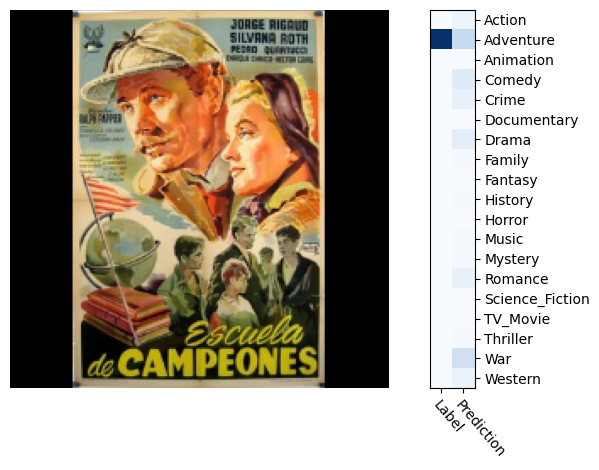

In [84]:
plot_random_datapoint(model, train_Data)

## One-vs-all multilabel classification

In [41]:
keras.backend.clear_session(free_memory=True)
N_GENRES = 4 if FAST_TRAIN else 19

In [42]:
class BinaryCNN:

    def __init__(self, frozen_layers: keras.Model, genre: str):
        self.genre = genre

        input_layer = layers.Input(shape=(224, 224, 3))
        x = frozen_layers(input_layer, training=False)

        x = layers.Dense(1000, name="dense_1")(x)
        x = layers.BatchNormalization(name="norm_1")(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(256, name="dense_2")(x)
        x = layers.BatchNormalization(name="norm_2")(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.3)(x)

        out = layers.Dense(1, "sigmoid", name="out_layer")(x)

        self.model = keras.Model(input_layer, out, name=f"{genre}_classifier")
        self.model.compile(
            optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "recall"]
        )

    def fit(self, train_data, val_data):

        train_data = self.binarizeDataset(train_data)
        val_data = self.binarizeDataset(val_data)

        earlyStop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)
        self.model.fit(
            train_data,
            batch_size=BATCH_SIZE,
            epochs=MAX_EPOCHS,
            validation_data=val_data,
            callbacks=[earlyStop],
        )

    def evaluate(self, test_data: tf.data.Dataset) -> tuple[float]:
        test_data = self.binarizeDataset(test_data)
        return self.model.evaluate(test_data, batch_size=BATCH_SIZE)

    def predict(self, img: np.ndarray) -> float:
        return self.model.predict(img, verbose=False)

    def binarizeDataset(self, dataset: tf.data.Dataset) -> tf.data.Dataset:
        mask = oneHotEncoder.transform([self.genre])[0]

        binDataset = dataset.unbatch()
        binDataset = binDataset.map(
            lambda img, label: (img, tf.reduce_sum(label & mask))
        )
        binDataset = binDataset.batch(
            batch_size=BATCH_SIZE, num_parallel_calls=True, deterministic=False
        )

        return binDataset


class MultiLabelCNN:
    genres: list[str] = []
    binaryClassifiers: dict[str, BinaryCNN] = {}
    perf: dict[str, tuple] = {}

    def __init__(self, genre_list: list[str]):
        self.genres = genre_list.copy()
        self.split_ratio = 70 / 30
        efficientNet = keras.applications.EfficientNetV2B0(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3),
            pooling="avg",
        )
        efficientNet.trainable = False

        for genre in genre_list:
            self.binaryClassifiers[genre] = BinaryCNN(efficientNet, genre)

    def fit(self):
        for genre in self.genres:
            X, Y = self.getBalancedData(genre)
            train_Data, val_Data, test_Data = make_splits(X, Y)
            print(f"Training classifier for genre: {genre}")
            self.binaryClassifiers[genre].fit(train_Data, val_Data)

            loss, acc, recall = self.binaryClassifiers[genre].evaluate(test_Data)
            self.perf[genre] = (loss, acc, recall)

    def predict(self, img: np.ndarray) -> np.array:
        result = np.zeros(19, dtype=float)
        for i, genre in enumerate(self.genres):
            result[i] = self.binaryClassifiers[genre].predict(img)
        return result

    def getPerfReport(self):
        rows = [[k, *v] for k, v in self.perf.items()]
        return pd.DataFrame(rows, columns=["genre", "loss", "accuracy", "recall"])

    def getBalancedData(self, genre: str) -> pd.DataFrame:
        movie_IDs = load_ids((SUBSAMPLING_COEFF < 1))
        groups = load_labels(movie_IDs).groupby("genre")
        num_genre_IDs = len(groups.get_group(genre))
        num_samples = min(num_genre_IDs, 10_000)

        # This check is needed to avoid over-sampling smaller classes
        # while preserving the overall class balance
        if (n := min(groups.count()["id"])) < (num_samples * self.split_ratio / 19):
            num_samples = int(n * 19 / self.split_ratio) - 1

        groups = groups.apply(
            lambda group: group.sample(
                n=(
                    num_samples
                    if group.name == genre
                    else int(num_samples * self.split_ratio / 19)  # 70/30 split
                )
            ),
        )
        groups = groups.reset_index(drop=True)
        return groups["id"].to_list(), groups["genre"].to_list()

In [43]:
multiLabel = MultiLabelCNN(genres[:N_GENRES])

In [ ]:
multiLabel.fit()

In [45]:
multiLabel.getPerfReport()

,genre,loss,accuracy,recall
0,Action,0.535619,0.741562,0.496994
1,Adventure,0.575162,0.710625,0.479920
2,Animation,0.374045,0.832812,0.727912
3,Comedy,0.549813,0.709687,0.514028
4,Crime,0.595084,0.675625,0.524574
5,Documentary,0.518910,0.748750,0.505020
6,Drama,0.570396,0.694687,0.508526
7,Family,0.503477,0.760625,0.500000
8,Fantasy,0.583475,0.700312,0.464393
9,History,0.573810,0.704063,0.372116


In [46]:
ids = load_ids()
multi_df = load_labels(ids, multiLabel=True)
multi_df = multi_df.groupby("id").filter(
    lambda group: len(set(genres[:N_GENRES]).intersection(group["genre"].to_list())) > 1
)
multi_df = encode_labels(multi_df)

/tmp/ipykernel_345656/79802056.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i] = self.binaryClassifiers[genre].predict(img)


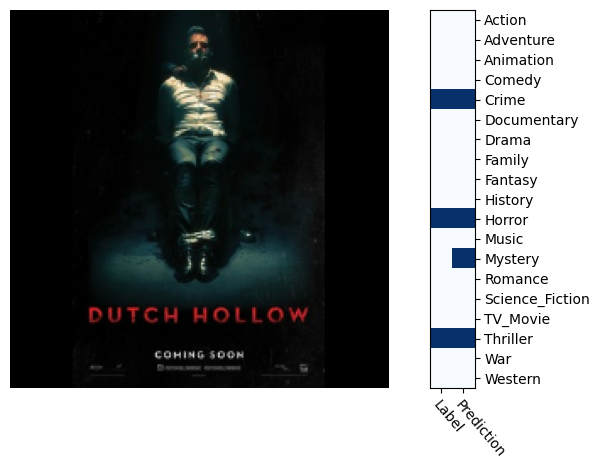

In [99]:
random_poster = multi_df.sample(1)

img_file = os.path.join(IMG_PATH, str(random_poster.index[0]) + ".jpg")
x, y = load_image({"img": img_file, "label": random_poster["label"]})
prediction = multiLabel.predict(tf.reshape(x, (1, *IMG_SHAPE)))
prediction = prediction > 0.5  # Binarize the prediction
plot_datapoint(x, np.array(*y), prediction)